In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [3]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [4]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Importing in GJ1243 light curve (DR-25)

In [5]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


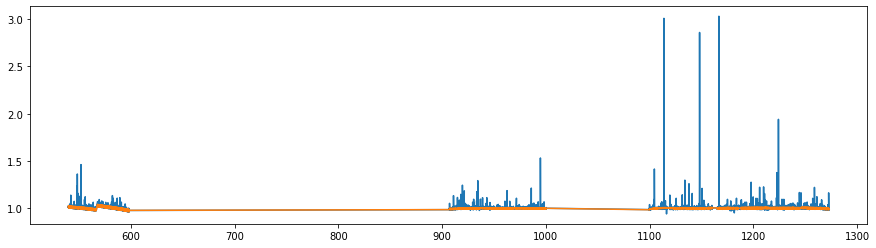

In [6]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*11mo_*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


In [7]:
print(len(df['df_flux_err']))

453111


In [8]:
#dropping the nans in the table
df = df.dropna()
df = df.reset_index(drop=True)
print(len(df))

453111


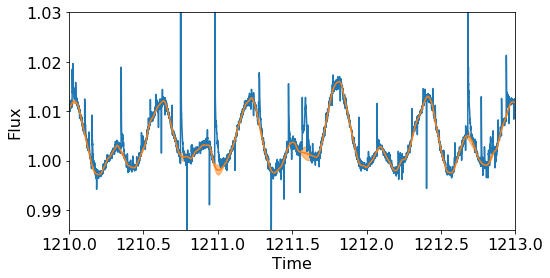

In [9]:
plt.figure(figsize=(8,4))
font = {'size'   : 16}
plt.rc('font', **font)
color = "#ff7f0e"
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')

plt.xlim(1210,1213)
plt.ylim(.986,1.03)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

In [10]:
detrended = df['detrended_flux'].values - df['mean'].values
#print(detrended)

### Interpolating over full light curve 

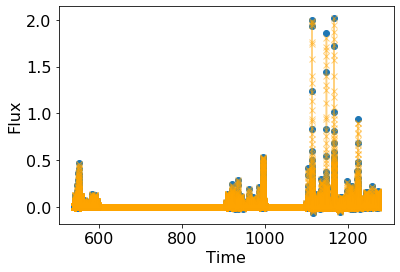

In [11]:
#interpolating the full light curve
plt.scatter(df['time'],detrended)

plt.xlabel("Time")
plt.ylabel("Flux")

padding_factor = 10
steps = padding_factor*len(detrended)

xvals = np.linspace(539.460, 1273.07, steps)
yinterp = np.interp(xvals, df['time'], detrended)
plt.plot(xvals,yinterp,'-x',color='orange',alpha=0.5)

In [12]:
#timed_classical
classic_start=timed_classical.loc[:,'t_start'].values
classic_stop=timed_classical.loc[:,'t_stop'].values
classic_dur = timed_classical.loc[:,'Flare_Duration'].values
#print(classic_start)

#### Finding the flux and time values where local maxes occur w/in interpolated data (i.e where the flares happen)

In [13]:
time_max = np.array([])
peaks = np.array([])
t_halfs = np.array([])
for i in range(0,len(timed_classical)):
    #for interpolated data
    temp1 = np.where((xvals < timed_classical['t_stop'].values[i]) & 
                    (xvals > timed_classical['t_start'].values[i]))[0]
    
    #for normal data
    temp2 = np.where((df['time'] < timed_classical['t_stop'].values[i]) & 
                    (df['time'] > timed_classical['t_start'].values[i]))[0]
    
    i_max = np.argmax(detrended[temp2])
    t_max = (df['time'].values[temp2][i_max])
    flux_max = (detrended[temp2][i_max])
    time_max = np.append(time_max,t_max)
    peaks = np.append(peaks,flux_max)
    half_peaks = peaks/2.0
    i_xs = np.where((yinterp[temp1] > half_peaks[i]))[0]
    time_xs = xvals[temp1][i_xs]
    t_half = max(time_xs) - min(time_xs)
    t_halfs = np.append(t_halfs,t_half)
    flux_fwhm = np.where(yinterp > half_peaks[i])[0]  #fluzes above the fwhm 
    
#####################################################################################    
    #plotting and saving 902 flares 
#####################################################################################    
    
    #plt.figure(figsize=[12,6])
    
    #plt.scatter(time_max[i],peaks[i],color='blue',label='peak',s=50)
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    ##plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    ##plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    #plt.axvline(x=classic_start[i], color='green', linestyle='-',alpha=0.7)
    #plt.axvline(x=classic_stop[i], color='green', linestyle='-',alpha=0.7)
    

    #plt.ylim(-.002,timed_classical['flux peak'].values[i]+.005)
    ##plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    #plt.xlim(timed_classical['t_start'].values[i]-.005*classic_dur[i],timed_classical['t_stop'].values[i]+.005*classic_dur[i])
    #plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    #plt.title('Flare:'+ str(i))
    #plt.xlabel('Time')
    #plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/flares/notebooks/flare_diagnostics/'+'flare'+str(i)+'.png',bbox_inches='tight')
    #plt.close()

In [14]:
print(len(t_halfs))
print(len(peaks))
print(len(time_max))
print(len(yinterp))
print(len(xvals))
print(len(flux_fwhm))

902
902
902
4531110
4531110
134306


### Plotting the Stacked Flares

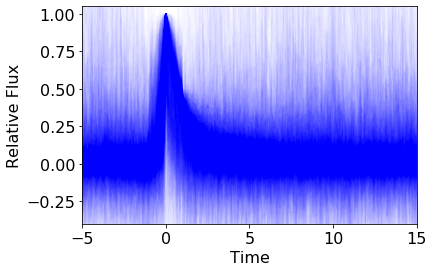

In [15]:
for i in range(0,len(timed_classical)):
        x = (df['time'] - time_max[i])/(t_halfs[i])
        y = ((detrended)/(peaks[i]))
        plt.plot(x,y,color='b',alpha=0.01)


        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)
        #plt.ylim(-0.4,1.5)


### Flare Diagnostics on 902 classical flares

In [ ]:
# have the padding be +/- duration = timed_clasical[t_start]-t_stop
#len(timed_classical)
''''
for i in range(0,len(timed_classical)):
    plt.figure(figsize=[12,6])
    flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    plt.scatter(time_max[i],peaks[i],color='blue',label='peak',s=50)
    plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=classic_start[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=classic_stop[i], color='green', linestyle='-',alpha=0.7)
    

    plt.ylim(-.002,timed_classical['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(timed_classical['t_start'].values[i]-.005*classic_dur[i],timed_classical['t_stop'].values[i]+.005*classic_dur[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.savefig('/Users/lupitatovar/flares/notebooks/flare_diagnostics/'+'flare'+str(i)+'.png',bbox_inches='tight')
    plt.close()
''''

In [ ]:
#notebook kept dying so had to split up the flares into two batches
''''
for i in range(533,len(timed_classical)):
    plt.figure(figsize=[12,6])
    flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    plt.scatter(time_max[i],peaks[i],color='blue',label='peak',s=50)
    plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=classic_start[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=classic_stop[i], color='green', linestyle='-',alpha=0.7)
    

    plt.ylim(-.002,timed_classical['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(timed_classical['t_start'].values[i]-.005*classic_dur[i],timed_classical['t_stop'].values[i]+.005*classic_dur[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.savefig('/Users/lupitatovar/flares/notebooks/flare_diagnostics/'+'flare'+str(i)+'.png',bbox_inches='tight')
    plt.close()
    
''''

### Cleaning up the Flare Sample
Flares to use below

In [16]:
new_flares=pd.read_csv('/Users/lupitatovar/flares/notebooks/flare_diagnostics/flare_diagnostics.csv',
            delim_whitespace=True,names=["Flare_Number","Type","Notes"])

In [17]:
flag = pd.to_numeric(new_flares["Type"].values, errors='coerce') #nan = classical , 2= adjust start/stop , 3= remove

In [38]:
# Separating the new set of flares and printing new ammounts of flares

still_classical = len(np.where(np.isnan(flag))[0])
print ("The number of remaining classical flares : " + str(still_classical)) 

toss = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(toss)) 

edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
edit_times = new_flares[new_flares["Type"].values == '2']
toss_flares = new_flares[new_flares["Type"].values == '3']
still_classic_flares = new_flares[pd.isnull(new_flares["Type"].values)]

#includes falres that need start/stop times edited
keep_flares = edit_times.combine_first(still_classic_flares)

The number of remaining classical flares : 476
The number flares tossed out : 341
The number of flares who need edited times : 83


In [48]:
#adding index column to Jim's original timed_calssical flares list
#timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

,"index of flare start in ""gj1243_master_slc.dat""","index of flare stop in ""gj1243_master_slc.dat""",t_start,t_stop,t_peak,t_rise,t_decay,flux peak,ED,Duration of rise,Duration of decay,Complex flag,# of people that identified flare event exists,# of people that analyzed this month,# of flare template components fit to event,Flare_Duration,Index
1,275.0,310.0,539.646668,539.671143,539.650024,0.003357,0.021118,0.005733,2.601320,0.291359,2.309961,1.0,8.0,8.0,2.0,35.244144,0
5,594.0,614.0,539.865967,539.880249,539.870056,0.004089,0.010193,0.004795,0.978497,0.187819,0.790678,1.0,8.0,8.0,1.0,20.566368,1
16,1262.0,1288.0,540.326416,540.344788,540.328491,0.002075,0.016296,0.002447,1.303812,0.137945,1.165867,1.0,5.0,8.0,1.0,26.455104,2
17,1305.0,1337.0,540.356384,540.378174,540.358459,0.002075,0.019714,0.003394,2.770375,0.084208,2.686167,1.0,8.0,8.0,1.0,31.376880,3
33,2146.0,2170.0,540.934692,540.951050,540.944214,0.009522,0.006836,0.002977,1.155527,0.483659,0.671868,1.0,8.0,8.0,1.0,23.554656,4
41,2438.0,2459.0,541.142456,541.156738,541.144470,0.002014,0.012268,0.006591,2.378301,0.567651,1.810650,1.0,8.0,8.0,1.0,20.566368,5
42,2475.0,2517.0,541.167664,541.196899,541.173096,0.005432,0.023804,0.010578,4.931096,1.413226,3.517869,1.0,8.0,8.0,1.0,42.099552,6
43,2565.0,2587.0,541.229614,541.245300,541.232361,0.002747,0.012940,0.005510,1.937838,0.650844,1.286994,1.0,8.0,8.0,1.0,22.587840,7
46,2702.0,2725.0,541.323608,541.339294,541.325684,0.002075,0.013611,0.015069,3.637085,0.949929,2.687156,1.0,8.0,8.0,1.0,22.587840,8
48,2825.0,2852.0,541.408081,541.426453,541.410095,0.002014,0.016357,0.010596,3.733333,0.904708,2.828625,1.0,8.0,8.0,1.0,26.454960,9


In [52]:
#cross matching the two lists to get new table that has all the flare info!

#cross_match = pd.merge(left=timed_classical, right=keep_flares, left_on='Index', right_on='Flare_Number')
cross_match.shape
cross_match


,"index of flare start in ""gj1243_master_slc.dat""","index of flare stop in ""gj1243_master_slc.dat""",t_start,t_stop,t_peak,t_rise,t_decay,flux peak,ED,Duration of rise,Duration of decay,Complex flag,# of people that identified flare event exists,# of people that analyzed this month,# of flare template components fit to event,Flare_Duration,Index,Flare_Number,Type,Notes
0,275.0,310.0,539.646668,539.671143,539.650024,0.003357,0.021118,0.005733,2.601320,0.291359,2.309961,1.0,8.0,8.0,2.0,35.244144,0,0.0,NaN,NaN
1,594.0,614.0,539.865967,539.880249,539.870056,0.004089,0.010193,0.004795,0.978497,0.187819,0.790678,1.0,8.0,8.0,1.0,20.566368,1,1.0,NaN,NaN
2,2146.0,2170.0,540.934692,540.951050,540.944214,0.009522,0.006836,0.002977,1.155527,0.483659,0.671868,1.0,8.0,8.0,1.0,23.554656,4,4.0,2,adjust
3,2438.0,2459.0,541.142456,541.156738,541.144470,0.002014,0.012268,0.006591,2.378301,0.567651,1.810650,1.0,8.0,8.0,1.0,20.566368,5,5.0,NaN,NaN
4,2475.0,2517.0,541.167664,541.196899,541.173096,0.005432,0.023804,0.010578,4.931096,1.413226,3.517869,1.0,8.0,8.0,1.0,42.099552,6,6.0,NaN,NaN
5,2565.0,2587.0,541.229614,541.245300,541.232361,0.002747,0.012940,0.005510,1.937838,0.650844,1.286994,1.0,8.0,8.0,1.0,22.587840,7,7.0,NaN,NaN
6,2702.0,2725.0,541.323608,541.339294,541.325684,0.002075,0.013611,0.015069,3.637085,0.949929,2.687156,1.0,8.0,8.0,1.0,22.587840,8,8.0,NaN,NaN
7,2825.0,2852.0,541.408081,541.426453,541.410095,0.002014,0.016357,0.010596,3.733333,0.904708,2.828625,1.0,8.0,8.0,1.0,26.454960,9,9.0,NaN,NaN
8,3022.0,3072.0,541.542969,541.578369,541.546326,0.003357,0.032044,0.015992,11.158404,1.359274,9.799130,1.0,8.0,8.0,2.0,50.976432,10,10.0,NaN,NaN
9,3379.0,3406.0,541.790222,541.808594,541.791565,0.001343,0.017029,0.011324,4.100434,0.348273,3.752161,1.0,8.0,8.0,2.0,26.455104,11,11.0,NaN,NaN


In [59]:
new_time_max = np.array([])
new_peaks = np.array([])
new_t_halfs = np.array([])
for i in range(0,len(cross_match)):
    #for interpolated data
    temp1 = np.where((xvals < cross_match['t_stop'].values[i]) & 
                    (xvals > cross_match['t_start'].values[i]))[0]
    
    #for normal data
    temp2 = np.where((df['time'] < cross_match['t_stop'].values[i]) & 
                    (df['time'] > cross_match['t_start'].values[i]))[0]
    
    i_max = np.argmax(detrended[temp2])
    t_max = (df['time'].values[temp2][i_max])
    flux_max = (detrended[temp2][i_max])
    new_time_max = np.append(new_time_max,t_max)
    new_peaks = np.append(new_peaks,flux_max)
    nhalf_peaks = new_peaks/2.0
    i_xs = np.where((yinterp[temp1] > nhalf_peaks[i]))[0]
    time_xs = xvals[temp1][i_xs]
    t_half = max(time_xs) - min(time_xs)
    new_t_halfs = np.append(new_t_halfs,t_half)
    flux_fwhm = np.where(yinterp > half_peaks[i])[0]  #fluxes above the fwhm 

In [57]:
print(len(new_peaks))

558


## Stacked flares with newly vetted flare list

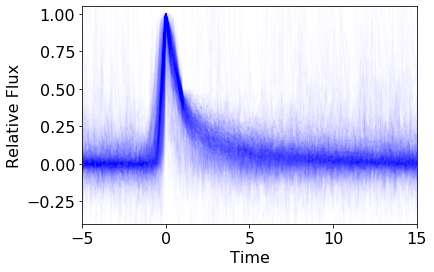

In [62]:
#New stack of flares

for i in range(0,len(cross_match)):
        x_new = (df['time'] - new_time_max[i])/(new_t_halfs[i])
        y_new = ((detrended)/(new_peaks[i]))
        plt.plot(x_new,y_new,color='b',alpha=0.01)


        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)

### Overplotting Jim's flare model onto this w/ amp=1,t_half=1,peak=0
https://github.com/jradavenport/appaloosa/blob/master/appaloosa/aflare.py

In [ ]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

In [ ]:
plt.plot(x,aflare1(x.values,0,1,1))
#plt.plot(x,jim_model,color='red')
plt.xlim(-5,15)

The arrays below contain time, flux, flux_err, and standard deviation for each flare within the ranges of [-5,15]

In [ ]:
x_all=np.array([])
y_all=np.array([])
y_err = np.array([])
gp_st_dev = np.array([])
xmin=-5
xmax=15

for i in range(0,len(timed_classical)):
        x = (df['time'].values - time_max[i])/(t_halfs[i])
        y = ((detrended)/(peaks[i]))
        plt.plot(x,y,color='b',alpha=0.01)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)
        
        #Time Arrays
        xs = np.where((x <= xmax) & (x>=xmin))[0]
        x_all = np.append(x_all,x[xs])
        
        #Flux Arrays
        y_all = np.append(y_all,y[xs])
        
        #Flux Errors
        flux_err = df['df_flux_err'].values/peaks[i] 
        y_err = np.append(y_err,flux_err[xs])
        
        #GP Standard Deviation
        st_dev = df['std'].values/peaks[i]
        gp_st_dev = np.append(gp_st_dev,st_dev[xs])
                  
plt.plot(x,aflare1(x,0,1,1),color='red',label='Jims Model')        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
#saving the arrays to a file
#dict_i = {'time':x_all,'flux': y_all, 'flux_err': y_err, 'gp_st_dev': gp_st_dev} 
#stacked_flares = pd.DataFrame(data=dict_i) 
#stacked_flares.to_csv(r'stacked_flare_values.csv',header=True,index=True)

In [ ]:
#stacked_flare_vals=pd.read_csv('stacked_flare_values.csv')

In [ ]:
s_all = np.argsort(x_all)
jim_model = aflare1(x_all,0,1,1)
plt.scatter(x_all,y_all,alpha=.07,s=10,marker='.')
plt.ylim(-0.4,1.05)
plt.plot(x_all[s_all],jim_model[s_all],color='red')  
plt.xlabel('Time')
plt.ylabel('Relative Flux')

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
#plot of the gp uncertainty in our detrended data
plt.scatter(x_all,gp_st_dev,alpha=.05,s=10,marker='.')
plt.ylim(0,.2)

Below is the flux error from the gp. We expect it to be a straight line centered at zero, however there is some variance between 0-0.3

In [ ]:
#plot the rolling mean and y_err

plt.scatter(x_all,y_err,alpha=.05,s=8,marker='.')
#plt.ylim(0,1)

In [ ]:
#plotting the variance of the st_dev (which is just the st_dev squared?)
plt.scatter(x_all,gp_st_dev**2,alpha=.05,s=10,marker='.')
plt.ylim(0,.2)

### Fitting the Model

Importing in the new continuous model

In [ ]:
'''
Now lets combine the two functions into one continuous analytic flare model

    Parameters (similar as Davenport 2014 aflare1 model)
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    t_0 : float
        The time of the flare peak
    sig/tau : float
        The "Full Width at Half Maximum", timescale of the flare
    A/amp : float
        The amplitude of the flare
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

'''
def gaussian(t,A, t_0, sig):
    return A*np.exp((-(t-t_0)**2) / (2*sig**2))
def double_exp(t,amp1,t_01,tau1,amp2,t_02,tau2):
    return amp1*np.exp((-(t-t_01)/tau1)) + amp2*np.exp((-(t-t_02)/tau2))

def single_exp(t,amp):
    return amp*np.exp(-t)

def single_flare_model(t,A,t_0,sig,amp):
    template = (gaussian(t,A,t_0,sig)) * (single_exp(t,amp))
    return template

def flare_model(t,A,t_0,sig,amp1,t_01,tau1,amp2,t_02,tau2):
    flare = (gaussian(t,A,t_0,sig)) * (double_exp(t,amp1,t_01,tau1,amp2,t_02,tau2))
    return flare

Plotting the new model with some arbituary values to show it reads in the time array

In [ ]:
new_model = flare_model(x_all,0.3,0,1,1,0,1,1,0,1)
#flare_model(x_all,0.3,0,1,1,0,1,1,0,1)
#plt.scatter(x_all,y_all,alpha=.07,s=10,marker='.')
plt.plot(x_all[s_all],new_model[s_all],color='orange')
plt.plot(x_all[s_all],jim_model[s_all],color='red') 
#plt.ylim(-0.4,1.05)

In [ ]:
single_exp_model = single_flare_model(x_all,0.6,0,1,1)
#flare_model(x_all,0.3,0,1,1,0,1,1,0,1)
#plt.scatter(x_all,y_all,alpha=.07,s=10,marker='.')
plt.plot(x_all[s_all],single_exp_model[s_all],color='orange')
plt.plot(x_all[s_all],jim_model[s_all],color='red') 

In [ ]:
#ans, err = quad(single_integrand, 0, 1)
#print(ans)

Solution to the convolution of a gaussian and a single exponential from Gryciuk et al 2017:https://ui.adsabs.harvard.edu/abs/2017SoPh..292...77G/abstract

In [ ]:
from scipy import special
def integral_sol(t,a,b,c,d):
    z = ((2*b + c**2 *d)/(2*c))
    f_t = (1/2) * np.sqrt(np.pi) * a * c * np.exp(d*(b-t) + ((c**2 * d**2)/4))*(special.erf(z) - special.erf(z - (t/c)))
    return f_t

In [ ]:
plt.plot(x_all[s_all],integral_sol(x_all,1.4,3,1,1)[s_all])
plt.plot(x_all[s_all],jim_model[s_all],color='red')

Solution to the convolution of a gaussian and a double exponential: https://en.m.wikipedia.org/wiki/Convolution

In [ ]:
def integral_sol2(t,a,b,c,t01,t02,tau1,tau2,g,f):
    j = (((2*(t-b)*tau2) + c**2)/(2*c*tau2))
    k = (((2*b*tau2) + c**2)/(2*c*tau2))
    m = (((2*(t-b)*tau1) + c**2)/(2*c*tau1))
    n = (((2*b*tau1) - c**2)/(2*c*tau1))
    f_t2 = (1/2) * np.sqrt(np.pi) * a * c * np.exp(-((b*tau2+tau1)/(tau1*tau2))) * ((g*np.exp(((4*b*tau2**2) + (4*t02*tau1*tau2) + (c**2*tau1))/(4*tau1*tau2**2))*(special.erf(j) + special.erf(k)))+ (f*(special.erf(m) + special.erf(n))*np.exp((((4*t01*tau1) + c**2)*(tau2+(4*b*tau1**2))/(4*tau1**2*tau2)))))
    return f_t2

In [ ]:
plt.plot(x_all[s_all],integral_sol2(x_all,.3,0.3,1,0,0,1,1,1,1)[s_all])
plt.plot(x_all[s_all],jim_model[s_all],color='red')


#t,A,t_0,sig,amp1,t_01,tau1,amp2,t_02,tau2
 #x_all,0.3,0,1,1,0,1,1,0,1

Model used in Jackman paper

In [ ]:
def jackman(t,A,B,C,D1,D2,f1):
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    f_t2 = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t/C)))) 
                                             + (f2 * np.exp((D2*(B-t)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t/C)))))
    return f_t2

#D1 & D2 - gives the tail slope (influence decay)
#A&C influence the amplitude
#B shifts left and right (but also affects the rise phase A LOT)
#f1 barely affects the decay slope (have made this number positive and negative and the diffs are minimal)

In [ ]:
#plt.plot(x_all[s_all],jackman(x_all,6.5,.3,.1,1,1,-0.9)[s_all],label='Jackman')
plt.plot(x_all[s_all],jackman(x_all,57,.03,.01,.9,.9,-2)[s_all],label='Jackman')
plt.plot(x_all[s_all],jackman(x_all,6.7,.26,.1,1,1,2)[s_all],label='Jackman2')
plt.plot(x_all[s_all],jim_model[s_all],color='red',label='Jim')
plt.xlim(-4,5)
plt.legend()

In [ ]:
def gaussian(t,A, t_0, sig):
    return A*np.exp((-(t-t_0)**2) / (2*sig**2))
def double_exp(t,amp1,t_01,tau1,amp2,t_02,tau2):
    return amp1*np.exp((-(t-t_01)/tau1)) + amp2*np.exp((-(t-t_02)/tau2))

def single_exp(t,amp,tau):
    return amp*np.exp(-t/tau)

Comparing the integral result to numpy.convolve result

In [ ]:
gauss = gaussian(x_all,1,0,1)
doub_exp = double_exp(x_all,.01,.1,1,.01,1,1)
one_exp = single_exp(x_all,.03,1)
convolved = np.convolve(gauss[s_all],doub_exp[s_all],'same')
single_convolved = np.convolve(one_exp[s_all],gauss[s_all],'same')

In [ ]:
#plt.plot(x_all[s_all],convolved[s_all])
#plt.plot(convolved)
#plt.plot(x_all[s_all],gauss[s_all])
#plt.plot(x_all[s_all],doub_exp[s_all])
#plt.plot(x_all[s_all],one_exp[s_all])
plt.plot(x_all[s_all],convolved)
plt.plot(x_all[s_all],single_convolved)
#plt.ylim(0,5)

Modified Gaussian function, meaning the result of convolving a gaussian with an expoential decay that starts at t=0
https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution

In [ ]:
def ModifiedGaussian(t,A,mu,sigma,tau):
        x = 1./(2.*tau) * np.exp(.5*(sigma/tau)**2) * np.exp(- (t-mu)/tau)
        s = A*x*( 1. + special.erf((t-mu-sigma**2/tau)/np.sqrt(2*sigma**2)))
        return s

In [ ]:
plt.plot(x_all[s_all],ModifiedGaussian(x_all,3,0,.05,2.85)[s_all])
plt.plot(x_all[s_all],jim_model[s_all],color='red')
plt.xlim(-1,1)
#plt.legend()

### Now we fit for the parameters

In [ ]:
from scipy.optimize import least_squares,curve_fit, minimize


In [ ]:
#limiting the range of the x_all array to [-1,5]
#print(len(x_all))
#print(len(y_all))
#lim_xs=np.where((x_all > -1) & (x_all <5))[0]
#lim_ys = np.where((y_all > -0.15) & (y_all < 1.05))[0]
lim_xy = np.where((x_all > -1) & (x_all <5) & (y_all > -0.15) & (y_all < 1.05))[0]
#print(len(x_all[lim_xs]))
#print(len(y_all[lim_ys]))

x_all_lim = x_all[lim_xy]
y_all_lim = y_all[lim_xy]

#x_all_ylim = x_all[lim_ys]
#y_all_ylim = y_all[lim_ys]
#print(len(x_all_lim))
xysorter = np.argsort(x_all_lim)
#xsorter = np.argsort(x_all_xlim)
#ysorter = np.argsort(x_all_ylim)

## Fitting the double exponential

In [ ]:
#fitting using Jackman model (double exponential)
jackman_model = jackman(x_all,57,.03,.01,.9,.9,-2)[xysorter]

#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
init_vals = [57,.03,.01,.9,.9,-2]  
#init_vals = [0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682] 
jack_best_vals, jack_covar = curve_fit(jackman, x_all_lim[xysorter], y_all_lim[xysorter], p0=init_vals,maxfev=10000)
print('best_vals: {}'.format(jack_best_vals))

In [ ]:
#plt.figure(figsize=(6, 4))
plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter],*jack_best_vals),label='Fit',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
plt.show()

#### Testing out the fit using bounds & photometric errors

In [ ]:
#trying out bounds in curvefit

jackman_model = jackman(x_all,6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03)[xysorter]
#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
#init_vals = [6.5,.3,.1,1,1,-0.5]  
init_vals = [6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03] 
jack_best_vals, jack_covar = curve_fit(jackman,  x_all_lim[xysorter], y_all_lim[xysorter],  bounds = ((6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03),(70,.03,.01,1,1,-2)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(jack_best_vals))

#x bounds: 0.04562397   5.5760833    6.76383529   1.08299982   0.83006122  -20.82625395
#y bounds: 0.02641687  6.62134634  6.50814028  0.9669539   0.92302551 -6.28933267

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter],*jack_best_vals) ,
         label='Fit',color='red')
#plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

## Fiiting the single exponential

In [ ]:
#fitting using single exponential
#modified_model = ModifiedGaussian(x_all_lim,3,0,.05,2.85)[xysorter]
modified_model = ModifiedGaussian(x_all_lim,1.52463877, -0.35834599, -0.18916754,  2.18883967)[xysorter]
mod_init_vals =[1.52463877, -0.35834599, -0.18916754,  2.18883967]
mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,sigma=y_err[lim_xy])
print('best_vals: {}'.format(mod_best_vals))

In [ ]:
plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals) ,
         label='Fitted function',color='red')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

#### Testing out the fit using bounds & photometric errors

In [ ]:
#fitting with bounds that are based on the best fit values that were calculated using x&ylims
modified_model = ModifiedGaussian(x_all_lim,3,0,.05,2.85)[xysorter]
#mod_init_vals =[453.72458194, -107.91905345,  263.19153402,  436.28711402]
#mod_init_vals =[-33482.97946148,  204.6003791,   574.73593843, -78697.53865734]


#y bounds -33482.97946148    204.6003791     574.73593843 -78697.53865734
#x bounds -61222.51973875    563.89092049    992.84654422 -42925.53571468

mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],
                                                                 bounds =((1.52525575, -0.35800783, -0.18889691, 2.19077624),(2,-.2,-.05,3)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(mod_best_vals))

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals) ,
         label='Fitted function',color='red')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

### Troubleshooting bounds of the fit

In [ ]:
# time window of like -1 to 2 in x
# try just fitting certain sections of the data - like from -1 to 0.01, or -0.01 to 2


lim_xy = np.where((x_all > -.1) & (x_all <.1) & (y_all > -0.15) & (y_all < 1.05))[0]

x_all_lim = x_all[lim_xy]
y_all_lim = y_all[lim_xy]
xysorter = np.argsort(x_all_lim)

#### Double exponential

In [ ]:
#This is the fit when I limit x (-1,2)

jackman_model = jackman(x_all,6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03)[xysorter]
#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
#init_vals = [6.5,.3,.1,1,1,-0.5]  
init_vals = [6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03] 
jack_best_vals, jack_covar = curve_fit(jackman,  x_all_lim[xysorter], y_all_lim[xysorter],p0=init_vals,  bounds = ((6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03),(70,.03,.01,1,1,-2)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(jack_best_vals))

#plt.figure(figsize=(6, 4))
plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter],*jack_best_vals),label='Fit',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-1,0.01)

jackman_model = jackman(x_all,6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03)[xysorter]
#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
#init_vals = [6.5,.3,.1,1,1,-0.5]  
init_vals = [6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03] 
jack_best_vals, jack_covar = curve_fit(jackman,  x_all_lim[xysorter], y_all_lim[xysorter],p0=init_vals,  bounds = ((6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03),(70,.03,.01,1,1,-2)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(jack_best_vals))

#plt.figure(figsize=(6, 4))
plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter],*jack_best_vals),label='Fit',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-0.01,2)

jackman_model = jackman(x_all,6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03)[xysorter]
#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
#init_vals = [6.5,.3,.1,1,1,-0.5]  
init_vals = [6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03] 
jack_best_vals, jack_covar = curve_fit(jackman,  x_all_lim[xysorter], y_all_lim[xysorter],p0=init_vals,  bounds = ((6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03),(70,.03,.01,1,1,-2)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(jack_best_vals))

#plt.figure(figsize=(6, 4))
plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter],*jack_best_vals),label='Fit',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-.1,.1) with bounds

jackman_model = jackman(x_all,6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03)[xysorter]
#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
#init_vals = [6.5,.3,.1,1,1,-0.5]  
init_vals = [6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03] 
jack_best_vals, jack_covar = curve_fit(jackman,  x_all_lim[xysorter], y_all_lim[xysorter],p0=init_vals,  bounds = ((6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03),(70,.03,.01,1,1,-2)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(jack_best_vals))

#plt.figure(figsize=(6, 4))
plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter],*jack_best_vals),label='Fit',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-.1,.1) without bounds

jackman_model = jackman(x_all,6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03)[xysorter]
#jackman_model = jackman(x_all_ylim,0.02675881, 6.62072363, 6.51545681, 0.96707504, 0.92314355, -6.28890682)[ysorter]
#init_vals = [6.5,.3,.1,1,1,-0.5]  
init_vals = [6.24809994e+01,  1.39618218e-02,  4.53257289e-03,  9.00039771e-01,8.99778040e-01, -2.26811923e+03] 
jack_best_vals, jack_covar = curve_fit(jackman,  x_all_lim[xysorter], y_all_lim[xysorter],p0=init_vals,sigma=y_err[lim_xy])
print('best_vals: {}'.format(jack_best_vals))

#plt.figure(figsize=(6, 4))
plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter],*jack_best_vals),label='Fit',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
plt.show()

#### Single Exponential

In [ ]:
#This is the fit when I limit x (-1,2)
modified_model = ModifiedGaussian(x_all_lim,1.52525575, -0.35800783, -0.05 ,2.19077624)[xysorter]
mod_init_vals =[1.52525575, -0.35800783, -0.05 ,2.19077624]
mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,
                                                                 bounds =((1.52525575, -0.35800783, -0.18889691, 2.19077624),(2,-.2,-.05,3)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(mod_best_vals))

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals) ,
         label='Fitted function',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-1,0.01)
modified_model = ModifiedGaussian(x_all_lim,1.52525575, -0.35800783, -0.05 ,2.19077624)[xysorter]
mod_init_vals =[1.52525575, -0.35800783, -0.05 ,2.19077624]
mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,
                                                                 bounds =((1.52525575, -0.35800783, -0.18889691, 2.19077624),(2,-.2,-.05,3)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(mod_best_vals))

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals) ,
         label='Fitted function',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-0.01,2)
modified_model = ModifiedGaussian(x_all_lim,1.52525575, -0.35800783, -0.05 ,2.19077624)[xysorter]
mod_init_vals =[1.52525575, -0.35800783, -0.05 ,2.19077624]
mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,
                                                                 bounds =((1.52525575, -0.35800783, -0.18889691, 2.19077624),(2,-.2,-.05,3)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(mod_best_vals))

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals) ,
         label='Fitted function',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-0.1,.1)
modified_model = ModifiedGaussian(x_all_lim,1.52525575, -0.35800783, -0.05 ,2.19077624)[xysorter]
mod_init_vals =[1.52525575, -0.35800783, -0.05 ,2.19077624]
mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,
                                                                 bounds =((1.52525575, -0.35800783, -0.18889691, 2.19077624),(2,-.01,-.05,3)),sigma=y_err[lim_xy])
print('best_vals: {}'.format(mod_best_vals))

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals) ,
         label='Fitted function',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#This is the fit when I limit x (-0.1,.1) no bounds
modified_model = ModifiedGaussian(x_all_lim,0.17056828, -0.03996861, -0.05410323,  0.05788997)[xysorter]
mod_init_vals =[0.17056828, -0.03996861, -0.05410323,  0.05788997]
mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,sigma=y_err[lim_xy],maxfev=10000)
print('best_vals: {}'.format(mod_best_vals))

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals) ,
         label='Fitted function',color='red')

plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

plt.legend(loc='best')
plt.ylim(-0.25,1.05)
plt.show()

In [ ]:
#import os
#os.system("say “Finished”") 

In [ ]:
print(len(lim_xy))
print(len(xysorter))

Chi residual check

In [ ]:
#chi residual check
plt.plot(x_all_lim[xysorter],((y_all_lim[xysorter]- ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals))/y_err[xysorter]))

In [ ]:
#chi residual check
plt.plot(x_all_lim[xysorter],((y_all_lim[xysorter]- ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals))/y_err[lim_xy][xysorter]))

plt.ylim(-50,50)

In [ ]:
#make this plot
#This is the fit when I limit x (-1,2)

lim_xy = np.where((x_all > -1) & (x_all <2) & (y_all > -0.15) & (y_all < 1.05))[0]

x_all_lim = x_all[lim_xy]
y_all_lim = y_all[lim_xy]
xysorter = np.argsort(x_all_lim)

modified_model = ModifiedGaussian(x_all_lim,0.17055418, -0.03995083, -0.05411289,  0.05785364)[xysorter]
#mod_init_vals =[1.52525575, -0.35800783, -0.05 ,2.19077624]
mod_init_vals =[0.17055418, -0.03995083, -0.05411289,  0.05785364]
mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,sigma=y_err[lim_xy])
print('best_vals: {}'.format(mod_best_vals))

plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.17,s=10,marker='.',label='Data')

plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],*mod_best_vals)*1.4 ,
         label='Fitted function',color='red')

#plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

#This plot is using the values optimize gives when we only fit the peak at (-.1,.1)
plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],0.17055418, -0.03995083, -0.05411289,  0.05785364) ,
         label='peak_fit',color='green')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(-0.25,1.05)
plt.show()


#but add in the bounds for the limited range of just the peak 
#This is the fit when I limit x (-0.1,.1) no bounds
#modified_model = ModifiedGaussian(x_all_lim,0.17056828, -0.03996861, -0.05410323,  0.05788997)[xysorter]
#mod_init_vals =[0.17056828, -0.03996861, -0.05410323,  0.05788997]
#mod_best_vals, mod_covar = curve_fit(ModifiedGaussian, x_all_lim[xysorter], y_all_lim[xysorter],p0=mod_init_vals,sigma=y_err[lim_xy],maxfev=10000)
#print('best_vals: {}'.format(mod_best_vals))

#plt.scatter(x_all_lim[xysorter],y_all_lim[xysorter],alpha=.07,s=10,marker='.',label='Data')
#plt.plot(x_all_lim[xysorter], ModifiedGaussian(x_all_lim[xysorter],0.17055418, -0.03995083, -0.05411289,  0.05785364) ,
         #label='Fitted function',color='green')

#plt.plot(x_all_lim[xysorter], jackman(x_all_lim[xysorter], *init_vals),color='orange',label='init_vals')

#plt.legend(loc='best')
#plt.ylim(-0.25,1.05)
#plt.show()